# Attribution Demo Case 1: Standard

## Environment setup

In [1]:
import sys
sys.path.append("../src/")

## Basic configuration

In [2]:
from attribution.common.constants import wq
from attribution.attribution_core import (
    data_query, filtered_by_in, portfolio_weights_regularization
)

from attribution.attribution_class import Attribution, AttributionResult

2020-08-07 11:33:20,711 - lquantPy.LQuant - INFO - Initial LQuant. This may take some time...
2020-08-07 11:33:20,713 - lquantPy.LQuant - INFO - Initialized LQuant environment
2020-08-07 11:33:20,713 - lquantPy.LQuant - INFO - Initializing LQuant, This will take some time....


Library Path -Djava.library.path=/usr/local/lib/R/site-library/rJava/jri


In [3]:
sample_config = {
    "factor_universe": "CIQ_INDEX_2668794",
    "factor_universe_name": "Russell 1000",
    "port_id": "FS_Event_US",
    "port_name": "FS Event",
    "weight_tag": "WEIGHT",
    "style_factors": [
        "EPSYLD_LTM_B", "RTN_12M1M", "ES_EPS_NTM_R3M", "ROE",
        "REAL_VOL", "MKTCAP", "DIVYLD_TRL",
        "BOOKP", "GR_EINTR_EPS"
    ],
    "style_factor_names": [
        "Earnings Yld", "Momentum (12M-1M)", "Revision", "Profitability",
        "Volatility", "Size (MktCap)", "Dividend Yld",
        "Book To Market", "FY1/FY0 Exp Growth"
    ],
    "base_dir": "/mnt/ebs1/data/hwei/attribution/test/20200719",
}

## Get Portofolio Weight Matrix
- Raw data from data_query function
- market value from filtered_by_in function
- portofolio weight matrix from portfolio_weights_regularization function

In [4]:
def get_portfolio_date_list(port_id):
    var_name = "tmp"
    r_cmd = "{} <- wq.port.get(id = '{}')$dates()".format(var_name, port_id)
    wq.env().run(r_cmd)
    date_list = wq.env().get(var_name).as_string_array()
    wq.env().run("rm({})".format(var_name))
    return date_list

In [5]:
portfolio_date_list = get_portfolio_date_list(port_id=sample_config["port_id"])
print("Portfolio[{}], Start[{}], End[{}]".format(sample_config["port_id"], portfolio_date_list[0], portfolio_date_list[-1]))

Portfolio[FS_Event_US], Start[2009-12-31], End[2019-04-02]


In [6]:
raw_data = data_query(
    universe_name=sample_config["port_id"],
    date_list=portfolio_date_list,
    factor_list=["IN_{}".format(sample_config["port_id"]), "{}_{}".format(sample_config["port_id"], sample_config["weight_tag"])],
    s_date=None, e_date=None, freq=None, weekdays_only=False,
    local_mode=False, stocks=False, region=False
)

In [7]:
raw_data["IN_{}".format(sample_config["port_id"])].head()

,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,...,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-02-01,2019-03-04,2019-04-02
061302.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
163946.01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
029649.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105365.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
164494.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [8]:
raw_data["{}_{}".format(sample_config["port_id"], sample_config["weight_tag"])].head()

,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,...,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-02-01,2019-03-04,2019-04-02
061302.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.008496,-0.007895,-0.005339,-0.005153,-0.005146,-0.004664,-0.004488,-0.005303,NaN,NaN
163946.01,0.014763,0.014938,0.016899,0.019331,0.020677,0.021296,0.018412,0.016882,0.018243,0.015199,...,NaN,NaN,NaN,0.005023,0.006676,NaN,NaN,NaN,NaN,NaN
029649.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105365.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005186
164494.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.005455,-0.005514,-0.005807,NaN,NaN


In [9]:
market_value = filtered_by_in(
    signal_matrix=raw_data["{}_{}".format(sample_config["port_id"], sample_config["weight_tag"])],
    in_matrix=raw_data["IN_{}".format(sample_config["port_id"])]
)

In [10]:
market_value.head()

,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,...,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-02-01,2019-03-04,2019-04-02
061302.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.008496,-0.007895,-0.005339,-0.005153,-0.005146,-0.004664,-0.004488,-0.005303,NaN,NaN
163946.01,0.014763,0.014938,0.016899,0.019331,0.020677,0.021296,0.018412,0.016882,0.018243,0.015199,...,NaN,NaN,NaN,0.005023,0.006676,NaN,NaN,NaN,NaN,NaN
029649.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105365.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005186
164494.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.005455,-0.005514,-0.005807,NaN,NaN


In [11]:
portfolio_weight = portfolio_weights_regularization(
    portfolio=market_value, method="long_short"
)

In [12]:
portfolio_weight.head()

,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,...,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-02-01,2019-03-04,2019-04-02
061302.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.008496,-0.007895,-0.005339,-0.005153,-0.005146,-0.004664,-0.004488,-0.005303,0.0,0.000000
163946.01,0.014763,0.014938,0.016899,0.019331,0.020677,0.021296,0.018412,0.016882,0.018243,0.015199,...,0.000000,0.000000,0.000000,0.005023,0.006676,0.000000,0.000000,0.000000,0.0,0.000000
029649.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
105365.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.005186
164494.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.005455,-0.005514,-0.005807,0.0,0.000000


## Attribution class, CASE1, Standard
- Setup inputs and configurations
- Calculate
- Persist
- Get raw output data from calculation results
- Generate figures and PDF files

In [13]:
!rm -rf {sample_config["base_dir"]}
!mkdir -p {sample_config["base_dir"]}

In [14]:
attr_cls = Attribution()
attr_cls = attr_cls.set_output_dir(output_dir=sample_config["base_dir"])
attr_cls = attr_cls.set_output_file_name_prefix(file_name_prefix=sample_config["port_id"])
attr_cls = attr_cls.set_portfolio_matrix(portfolio_matrix=portfolio_weight)
attr_cls = attr_cls.run_with_daily_performance(run_daily=True)
attr_cls = attr_cls.set_sector_split_regex(
    patterns=["^(?!35)([0-9]{2})[0-9]{6}$", "^([0-9]{4})[0-9]{4}$"],
    replacements=["\\\\1", "\\\\1"]
)
attr_cls = attr_cls.load_axioma_idio_risk(load=True)
attr_cls = attr_cls.set_fmp_universe(fmp_universe=sample_config["factor_universe"], universe_id=True, universe_name=sample_config["factor_universe_name"])
attr_cls = attr_cls.set_style_factors(
    style_factors=sample_config["style_factors"],
    style_factor_names=sample_config["style_factor_names"]
)

rAttribution <- Attribution$new()
rAttribution <- rAttribution$setOutputDir(outputDir = '/mnt/ebs1/data/hwei/attribution/test/20200719')
rAttribution <- rAttribution$setOutputFileNamePrefix(fileNamePrefix = 'FS_Event_US', timeStamp = 'u%Y%m%d')
rAttribution <- rAttribution$setPortfolioMatrix(portfolioMatrix = pMat)
rm(pMat)
rAttribution <- rAttribution$runWithDailyPerformance(runDaily = TRUE)
rAttribution <- rAttribution$setSectorSplitRegex(patterns = c('^(?!35)([0-9]{2})[0-9]{6}$', '^([0-9]{4})[0-9]{4}$'), replacements = c('\\1', '\\1'))
rAttribution <- rAttribution$loadAxiomaIdioRisk(load = TRUE)
rAttribution <- rAttribution$setFmpUniverse(fmpUniverse = 'CIQ_INDEX_2668794', universeId = TRUE, universeName = 'Russell 1000', customizedInFmpMat = NULL)
rAttribution <- rAttribution$setStyleFactors(styleFactors = c('EPSYLD_LTM_B', 'RTN_12M1M', 'ES_EPS_NTM_R3M', 'ROE', 'REAL_VOL', 'MKTCAP', 'DIVYLD_TRL', 'BOOKP', 'GR_EINTR_EPS'), styleFactorNames = c('Earnings Yld', 'Momentum (12M-1M)', 'R

- Note, the calculation method will take relatively long to complete ...
- Therefore, usually it would be good to persist this for future use ...

In [15]:
attr_cls = attr_cls.calculate()

rAttribution <- rAttribution$calculate()


In [16]:
attr_cls.persist_class()

save(rAttribution, file = "rAttribution.RData")


In [17]:
!ls ./*.RData

./rAttribution.RData


- Get raw output data as a nested dictionary of dataframes from Attribution class

In [18]:
attr_raw_output_data = attr_cls.get_output_raw()

res <- rAttribution$getOutputRaw()
rm(res)


In [19]:
sorted(
    attr_raw_output_data.keys(),
    key=str.lower
)

['AttributionSummary',
 'AttributionSummary_PIT',
 'Bias Stat',
 'BrSum',
 'Concentration Analysis',
 'Correlation',
 'coverage',
 'Cum Portfolio Return Contribution',
 'Cum Residual Return Contribution',
 'Cum Return after Adv Cut',
 'Cum Return after Delta Adv Cut',
 'Cum Return Contribution',
 'Cum SecRetAlloc Contribution',
 'Cum StyleRetAlloc Contribution',
 'Cum StyleRetSelec Contribution',
 'dailyCumReturnContri',
 'dailyReturnContri_plain',
 'Delta Port Adj ADV Perc',
 'Exposure (Vol Adj)',
 'Factor Decile',
 'Factor Exposure',
 'Factor Gross Size',
 'Factor Score',
 'FMP Cum Return',
 'FMP Return',
 'fmpDailyCumReturns',
 'fmpDailyReturns',
 'Gross Wgt By Sec',
 'ICs',
 'Low Weight Cut_NUM',
 'Low Weight Cut_PERC',
 'Low Weight CutCUM_RETURN',
 'Low Weight CutRETURN',
 'LSreturns',
 'Net Wgt By Sec',
 'Port Adj ADV Perc',
 'Port Turnover',
 'Portfolio Turnover',
 'portfolio_smooth_CUM_RETURN',
 'portfolio_smooth_RETURN',
 'portfolio_smooth_TURNOVER',
 'Post Cut Residual_NUM',


In [20]:
attr_raw_output_data["AttributionSummary"].head()

,Factor Exposure,Factor Decile,Exposure (Vol Adj),Correlation,Risk Contribution,Risk Contribution(%),Return Contribution
Earnings Yld,0.310848,6.660714,0.005489,0.064755,0.000854,0.011255,0.001264
Momentum (12M-1M),0.729603,8.017857,0.015356,0.200838,0.004810,0.081538,0.007654
Revision,0.472194,7.151786,0.004230,0.001050,0.000241,0.005040,0.001721
Profitability,0.829760,8.392857,0.016326,0.039747,0.000566,0.014274,-0.009180
Volatility,-0.371439,4.062500,-0.018907,-0.366855,0.009191,0.140506,-0.000792


- Dump excel output

In [21]:
attr_cls = attr_cls.output_excel()

rAttribution <- rAttribution$outputExcel()


In [22]:
!ls {sample_config["base_dir"]}/data

FS_Event_US_u20200807_SummaryAndTS_20200807115126.xlsx


- Dump png output

In [23]:
attr_cls = attr_cls.output_charts()
attr_cls = attr_cls.output_pit_charts()

rAttribution <- rAttribution$outputCharts()
rAttribution <- rAttribution$outputPITCharts()


In [24]:
!ls -R {sample_config["base_dir"]}/charts

/mnt/ebs1/data/hwei/attribution/test/20200719/charts:
FS_Event_US_u20200807  FS_Event_US_u20200807_PIT

/mnt/ebs1/data/hwei/attribution/test/20200719/charts/FS_Event_US_u20200807:
0_1_summaryTable.png
0_2_residualTable.png
10_ReturnContri_Sectors.png
11_Performance_Sectors.png
12_1_ReturnContribution_Residuals.png
12_CumReturns_Residuals.png
13_Risk_vs_Return_Styles.png
14_Risk_vs_Return_Sectors.png
17_10_Communication_Sectors_Exp_vs_Return.png
17_11_Utilities_Sectors_Exp_vs_Return.png
17_12_Real Estate_Sectors_Exp_vs_Return.png
17_1_Energy_Sectors_Exp_vs_Return.png
17_2_Materials_Sectors_Exp_vs_Return.png
17_3_Industrials_Sectors_Exp_vs_Return.png
17_4_Con Discretionary_Sectors_Exp_vs_Return.png
17_5_Con Staples_Sectors_Exp_vs_Return.png
17_6_HealthCare E&S_Sectors_Exp_vs_Return.png
17_7_Pharm&Bio_Sectors_Exp_vs_Return.png
17_8_Financials_Sectors_Exp_vs_Return.png
17_9_Info Tech_Sectors_Exp_vs_Return.png
18_1_10_Communication_Alloc_Decomp_Sectors.png
18_1_11_Utilities_Alloc_Decomp_Sec

- Dump pdf output

In [25]:
attr_cls = attr_cls.set_pdf_title(
    title="{} Portfolio Historical Attribution".format(sample_config["port_name"])
)
attr_cls = attr_cls.set_pdf_title_pit(
    title="{} Portfolio Attribution Point-In-Time".format(sample_config["port_name"])
)
attr_cls = attr_cls.generate_historical_pdf()
attr_cls = attr_cls.generate_pit_pdf()

rAttribution <- rAttribution$setPDFTitle(title = 'FS Event Portfolio Historical Attribution')
rAttribution <- rAttribution$setPDFTitle_PIT(title = 'FS Event Portfolio Attribution Point-In-Time')
rAttribution <- rAttribution$generateHistoricalPDF()
rAttribution <- rAttribution$generatePITPDF()


In [26]:
!ls {sample_config["base_dir"]}/*.pdf

/mnt/ebs1/data/hwei/attribution/test/20200719/FS_Event_US_u20200807_Historical.pdf
/mnt/ebs1/data/hwei/attribution/test/20200719/FS_Event_US_u20200807_PIT.pdf


In [27]:
del attr_cls

## Visualization

- Bar plot, for example, AttributionSummary
- Heatmap, for example, ResidualComponents
- Table, for example, Summary
- Time series, for example, Cum Portfolio Return Contribution

- Create new class from persisted class

In [28]:
attr_cls = Attribution.load_from_local_file(
    file_path="./rAttribution.RData", obj_name="rAttribution"
)

rAttribution <- Attribution$new()
rm(rAttribution)
load(file = "./rAttribution.RData")


In [29]:
attr_raw_output_data = attr_cls.get_output_raw()

res <- rAttribution$getOutputRaw()
rm(res)


In [30]:
del attr_cls

In [31]:
%matplotlib inline

In [32]:
attr_res_cls = AttributionResult(attr_raw_output_data)

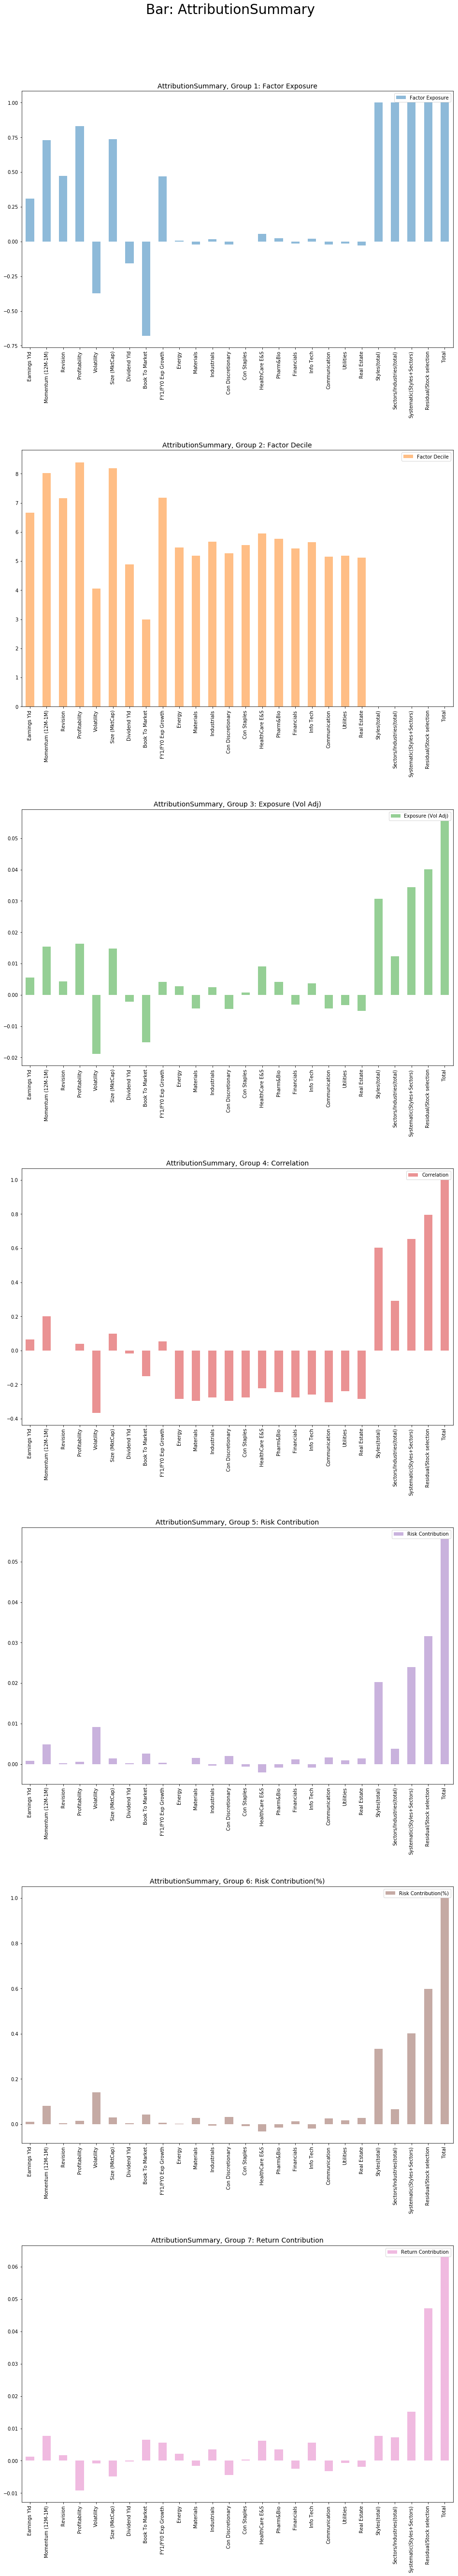

In [33]:
fig = attr_res_cls.plot_attribution_summary()

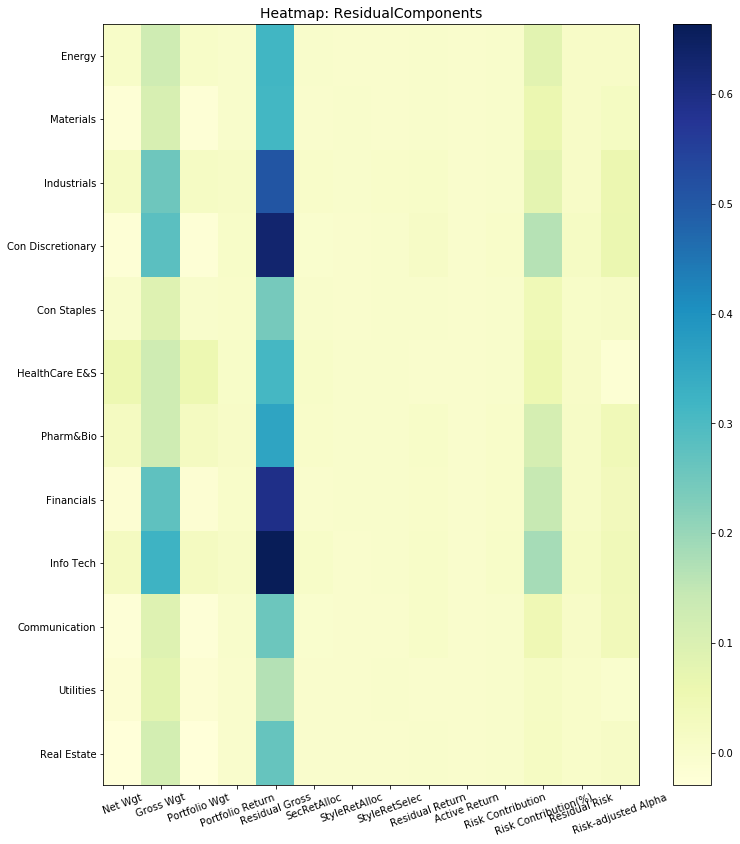

In [34]:
fig = attr_res_cls.plot_residual_components()

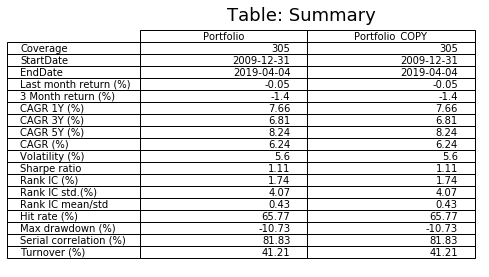

In [35]:
fig = attr_res_cls.plot_summary()

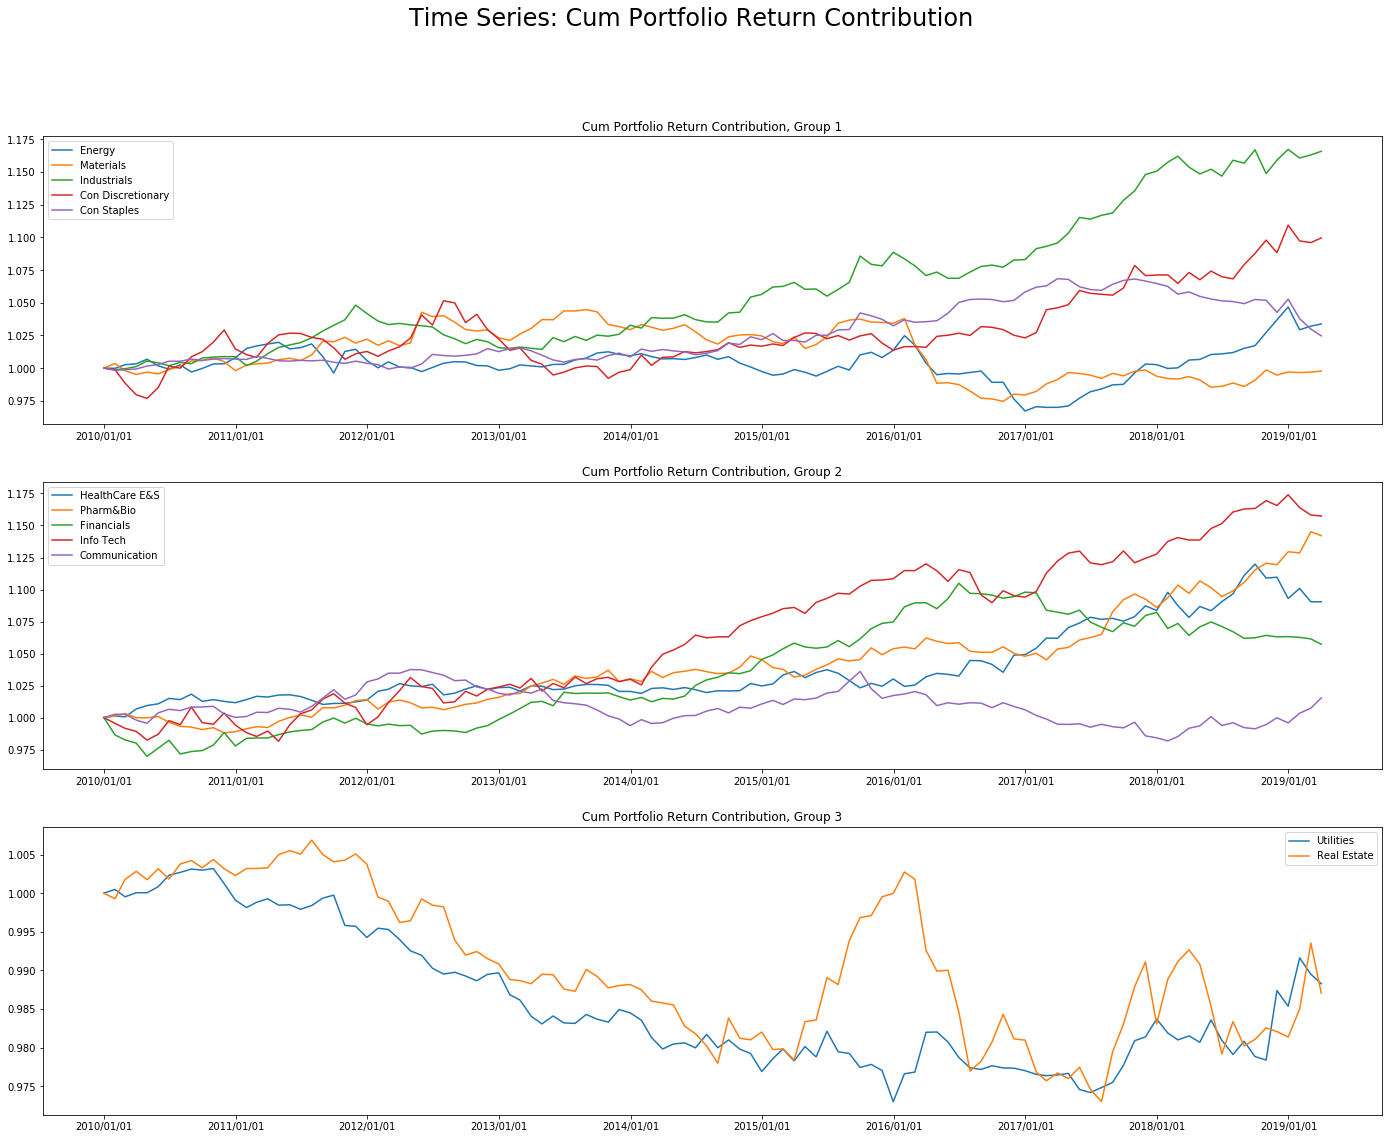

In [36]:
fig = attr_res_cls.plot_cum_portfolio_return_contribution()

In [37]:
del attr_res_cls

### End of file